In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pycaret
from pycaret.classification import *
#from pycaret.classification import ClassificationExperiment

from kmodes.kmodes import KModes
from sklearn.preprocessing import StandardScaler, LabelEncoder

import warnings
warnings.filterwarnings("ignore")

## Datasets

In [2]:
df = pd.read_csv('../../Data/cardio_data.csv')
df.head()

,age,gender,height,weight,systolic,diastolic,cholesterol,glucose,smoke,alcohol,active,cardiovascular_disease,BMI
0,50,2,168,62,110,80,1,1,0,0,1,0,21
1,55,1,156,85,140,90,3,1,0,0,1,1,34
2,51,1,165,64,130,70,3,1,0,0,0,1,23
3,48,2,169,82,150,100,1,1,0,0,1,1,28
4,47,1,156,56,100,60,1,1,0,0,0,0,23


## Transforming Dataset

In [3]:
# Transforming the column AGE(measured in days) for Age_Bin
# age_bin in quinquenium 5 years spam
df['age_bin'] = pd.cut(df['age'], [0,20,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100], 
                              labels=['0-20', '20-30', '30-35', '35-40','40-45','45-50','50-55','55-60','60-65','65-70','70-75','75-80','80-85','85-90','90-95','95-100'])

Here, I am grouping or binning `age` column into categories based on a 5-year interval. `Age_bin` is a variable or column name that likely contains individual age values, while `quinquenium` refers to a period of 5 years.

For example, if we have a dataset with age information, we can use this method to group the ages into 5-year intervals, such as 0-4 years, 5-9 years, 10-14 years, and so on. Each of these intervals can then be assigned a label or category, such as "0-4", "5-9", "10-14", etc., which can be used as input for statistical analyses or machine learning algorithms.

In [4]:
# Transforming the column bmi in Body Mass Index Classes (1 to 6)

# Adding Body Mass Index
df['bmi'] = df['weight']/((df['height']/100)**2)

rating = []
for row in df['bmi']:
    if row < 18.5 :    
        rating.append(1) #UnderWeight
    elif row > 18.5 and row  < 24.9:   
        rating.append(2) #NormalWeight
    elif row > 24.9 and row < 29.9:  
        rating.append(3) #OverWeight
    elif row > 29.9 and row < 34.9:  
        rating.append(4) #ClassObesity_1
    elif row > 34.9 and row < 39.9:  
        rating.append(5) #ClassObesity_2
    elif row > 39.9 and row < 49.9:  
        rating.append(6) #ClassObesity_3
    elif row > 49.9:  
        rating.append('Error')
        
    else:           
        rating.append('Not_Rated')

# inserting Column
df['BMI_Class'] = rating

In [5]:
# creating a Column for MAP
df['MAP'] = ((2* df['diastolic']) + df['systolic']) / 3

#Creating Classes for MAP
map_values = []
for row in df['MAP']:
    if row < 69.9:    
        map_values.append(1) #Low
    elif row > 70 and row  < 79.9:   
        map_values.append(2)#Normal
    elif row > 79.9 and row < 89.9:  
        map_values.append(3)#Normal
    elif row > 89.9 and row < 99.9:  
        map_values.append(4)#Normal
    elif row > 99.9 and row < 109.9:  
        map_values.append(5)#High
    elif row > 109.9 and row < 119.9:  
        map_values.append(6)#Normal
    elif row > 119.9:  
        map_values.append(7)
        
    else:           
        map_values.append('Not_Rated')

#inserting MAP_Class Column
df['MAP_Class'] = map_values

`Mean Arterial Pressure (MAP)` = ((2* Diastollic Blood Pressure) + Sistolic Blood Pressure) / 3

The overall blood pressure as measured in the brachial artery is maintained by the cardiac output and the total peripheral resistance (TPR) to flow. The mean arterial pressure (MAP) is calculated using the formula above

### Reordering Columns

In [6]:
df= df[["age","gender","height","weight","BMI","bmi","systolic","diastolic","MAP","age_bin","BMI_Class","MAP_Class","cholesterol","glucose","smoke","alcohol","active","cardiovascular_disease"]]
df.head()

,age,gender,height,weight,BMI,bmi,systolic,diastolic,MAP,age_bin,BMI_Class,MAP_Class,cholesterol,glucose,smoke,alcohol,active,cardiovascular_disease
0,50,2,168,62,21,21.967120,110,80,90.000000,45-50,2,4,1,1,0,0,1,0
1,55,1,156,85,34,34.927679,140,90,106.666667,50-55,5,5,3,1,0,0,1,1
2,51,1,165,64,23,23.507805,130,70,90.000000,50-55,2,4,3,1,0,0,0,1
3,48,2,169,82,28,28.710479,150,100,116.666667,45-50,3,6,1,1,0,0,1,1
4,47,1,156,56,23,23.011177,100,60,73.333333,45-50,2,2,1,1,0,0,0,0


In [7]:
# only Categorical Data Columns DataFrame
df_cat = df[["gender","age_bin","BMI_Class","MAP_Class","cholesterol","glucose","smoke","alcohol","active","cardiovascular_disease"]]

# Label encoder for categorical data column
le = LabelEncoder()
df_cat = df_cat.apply(le.fit_transform)
df_cat.head()

,gender,age_bin,BMI_Class,MAP_Class,cholesterol,glucose,smoke,alcohol,active,cardiovascular_disease
0,1,3,1,2,0,0,0,0,1,0
1,0,4,4,3,2,0,0,0,1,1
2,0,4,1,2,2,0,0,0,0,1
3,1,3,2,4,0,0,0,0,1,1
4,0,3,1,0,0,0,0,0,0,0


## K-Modes Analyses

In [8]:
# Splitting the dataset into male and female 
df_male = df_cat.query("gender == 0")
df_female = df_cat.query("gender == 1")

### Elbow Curve

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

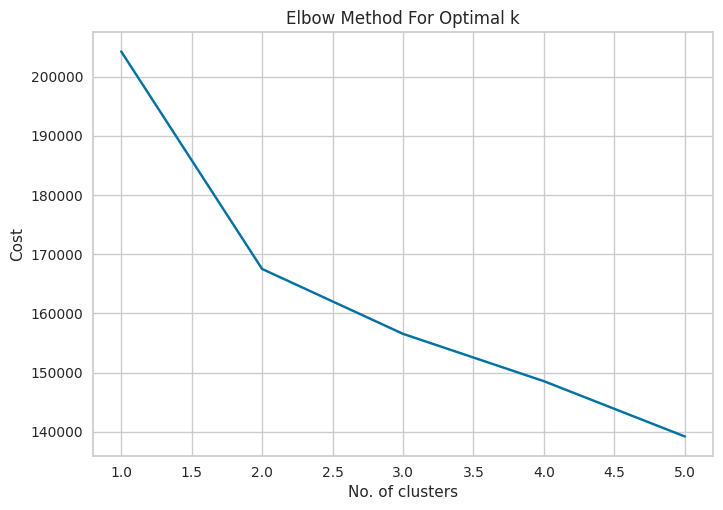

In [9]:
# Elbow curve to find optimal K in Huang init
cost = []
K = range(1,6)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "Huang", n_init = 5, verbose=0)
    kmode.fit_predict(df_cat)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

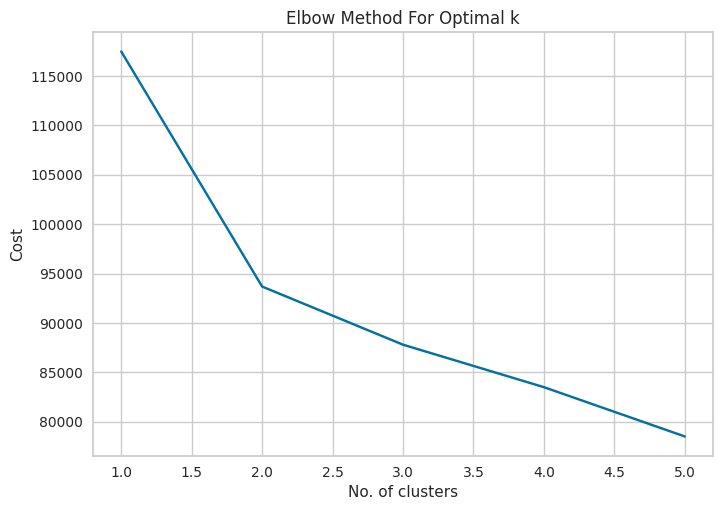

In [10]:
# For male data
# Elbow curve to find optimal K in Huang
cost = []
K = range(1,6)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "Huang", n_init = 5, verbose=0)
    kmode.fit_predict(df_male)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

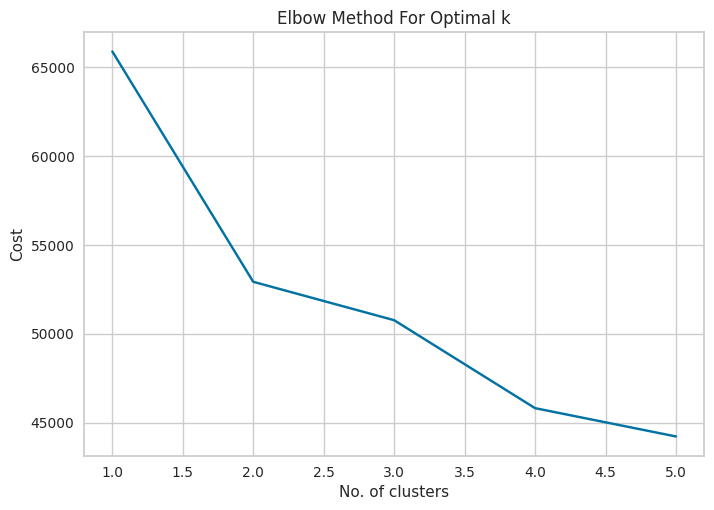

In [11]:
# For Female Data
# Elbow curve to find optimal K
cost = []
K = range(1,6)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "Huang", n_init = 5, verbose=0)
    kmode.fit_predict(df_female)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

The code above is using the `Elbow` method to find the optimal number of clusters (K) for the general dataset, male and female dataset using the `Huang` initialization method in the KModes clustering algorithm. The cost of the clustering is calculated for each value of K (ranging from 1 to 5) and plotted on a graph. The code then displays the graph with the number of `clusters` on the x-axis and the cost on the y-axis. The `Elbow` method is a heuristic method used to determine the optimal number of clusters based on the point of inflection in the cost graph (i.e., the elbow point).

The best number os clusters for the general data in `Huang` Init is **2**
The best number os clusters for male Data in `Huang` Init is **2**
The best number os clusters for female Data in `Huang` Init is **2**

### Building the model using K-Mode with Huang initialization

In [12]:
# female data
km_huang = KModes(n_clusters=2, init = "Huang", n_init = 5, verbose=0)
clusters_huang_1 = km_huang.fit_predict(df_female)
clusters_huang_1

array([1, 0, 0, ..., 0, 1, 1], dtype=uint16)

In [13]:
# male data
km_huang = KModes(n_clusters=2, init = "Huang", n_init = 5, verbose=0)
clusters_huang_2 = km_huang.fit_predict(df_male)
clusters_huang_2

array([0, 1, 0, ..., 1, 0, 0], dtype=uint16)

The code above is using the KModes clustering algorithm to build a model for both male & female dataset with two clusters, using the `Huang` initialization method.

The `KModes` algorithm is a clustering algorithm designed to work with categorical data. It groups together similar instances based on the similarity of their categorical attributes.

The `n_init` parameter specifies the number of times the algorithm will be run with different initial centroids. The verbose parameter controls the level of output messages printed during the clustering process.

The `fit_predict` method fits the model to the dataset (df_female & df_female) and returns an array of cluster assignments, where each element represents the cluster assignment for the corresponding row of the input data.

The `clusters_huang_1 & clusters_huang_2` variable contains the cluster assignments for each row in the df_female & df_male dataset respectively. This variable can be used to perform further analysis of the data, such as evaluating the quality of the clustering or identifying which instances belong to which cluster.

In [14]:
# Inserting clusters in DataFrame
df_female.insert(0,"Cluster", clusters_huang_1, True)
df_male.insert(0, "Cluster", clusters_huang_2, True)

In [15]:
df_female.head()

,Cluster,gender,age_bin,BMI_Class,MAP_Class,cholesterol,glucose,smoke,alcohol,active,cardiovascular_disease
0,1,1,3,1,2,0,0,0,0,1,0
3,0,1,3,2,4,0,0,0,0,1,1
7,0,1,6,3,3,2,2,0,0,1,1
11,1,1,4,1,2,0,0,0,0,1,0
12,1,1,1,1,2,0,0,0,0,0,0


In [16]:
df_male.head()

,Cluster,gender,age_bin,BMI_Class,MAP_Class,cholesterol,glucose,smoke,alcohol,active,cardiovascular_disease
1,0,0,4,4,3,2,0,0,0,1,1
2,1,0,4,1,2,2,0,0,0,0,1
4,0,0,3,1,0,0,0,0,0,0,0
5,0,0,5,2,2,1,1,0,0,0,0
6,0,0,5,4,2,2,0,0,0,1,0


In [17]:
# replacing cluster column values to merge dataframes after
df_male["Cluster"].replace({0:2, 1:3}, inplace=True)
df_male.head()

,Cluster,gender,age_bin,BMI_Class,MAP_Class,cholesterol,glucose,smoke,alcohol,active,cardiovascular_disease
1,2,0,4,4,3,2,0,0,0,1,1
2,3,0,4,1,2,2,0,0,0,0,1
4,2,0,3,1,0,0,0,0,0,0,0
5,2,0,5,2,2,1,1,0,0,0,0
6,2,0,5,4,2,2,0,0,0,1,0


In [18]:
# merging female and male data
df_clusters = pd.concat([df_female, df_male], ignore_index=True, sort=False)
df_clusters.head(10)

,Cluster,gender,age_bin,BMI_Class,MAP_Class,cholesterol,glucose,smoke,alcohol,active,cardiovascular_disease
0,1,1,3,1,2,0,0,0,0,1,0
1,0,1,3,2,4,0,0,0,0,1,1
2,0,1,6,3,3,2,2,0,0,1,1
3,1,1,4,1,2,0,0,0,0,1,0
4,1,1,1,1,2,0,0,0,0,0,0
5,1,1,5,1,1,0,0,1,0,1,0
6,1,1,4,3,2,0,0,0,0,1,0
7,1,1,1,1,2,0,0,0,0,1,0
8,0,1,5,2,2,0,2,0,0,0,0
9,0,1,5,2,3,2,0,0,0,0,1


### Correlation

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

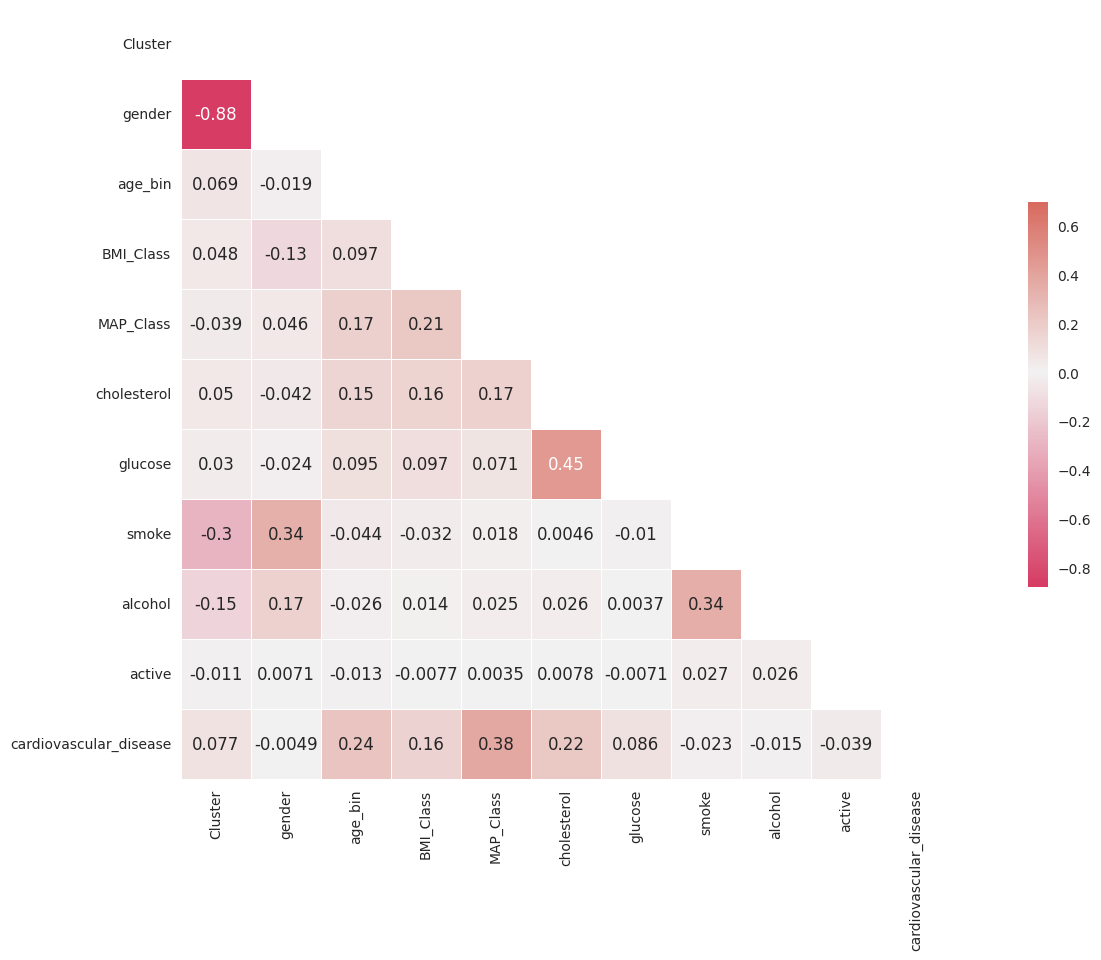

In [19]:
corr = df_clusters.corr()
cmap = sns.diverging_palette(2, 15, as_cmap=True)
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 10))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.7, center=0,annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

## Pycaret Experimentation

In [20]:
clf_exp = setup(data = df_clusters, target = 'cardiovascular_disease', session_id=123)

,Description,Value
0,session_id,123
1,Target,cardiovascular_disease
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(60144, 11)"
5,Missing Values,False
6,Numeric Features,0
7,Categorical Features,10
8,Ordinal Features,False
9,High Cardinality Features,False


In [21]:
best_model = compare_models(sort = 'F1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8674,0.9499,0.8374,0.8852,0.8606,0.7343,0.7354,2.2010
xgboost,Extreme Gradient Boosting,0.8653,0.9492,0.8371,0.8815,0.8587,0.7302,0.7311,4.7410
rf,Random Forest Classifier,0.8633,0.9449,0.8359,0.8786,0.8567,0.7261,0.7270,1.5280
gbc,Gradient Boosting Classifier,0.8617,0.9431,0.8358,0.8760,0.8553,0.7230,0.7239,2.3060
et,Extra Trees Classifier,0.8617,0.9392,0.8287,0.8813,0.8542,0.7228,0.7241,1.8460
dt,Decision Tree Classifier,0.8598,0.9355,0.8243,0.8813,0.8518,0.7190,0.7205,0.0770
knn,K Neighbors Classifier,0.8395,0.9188,0.8461,0.8296,0.8376,0.6790,0.6794,6.8870
lr,Logistic Regression,0.8234,0.9039,0.7981,0.8337,0.8155,0.6463,0.6469,2.3200
ada,Ada Boost Classifier,0.8137,0.9019,0.7625,0.8418,0.8001,0.6265,0.6293,0.8060
lda,Linear Discriminant Analysis,0.8125,0.9020,0.7654,0.8373,0.7997,0.6241,0.6264,0.4460


In [22]:
# # init the class
# exp = ClassificationExperiment()
# # init setup on exp
# exp.setup(df_clusters, target = 'cardiovascular_disease', session_id = 123)

In [23]:
# # compare models using OOP
# exp.compare_models(sort = 'Precision')

## Machine Learning

In [40]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, precision_recall_fscore_support, confusion_matrix, classification_report, plot_confusion_matrix

In [25]:
X = df_clusters.drop('cardiovascular_disease', axis=1)
y = df_clusters['cardiovascular_disease']

# Split the data into training and testing sets. 80% of data is training data, set aside other 20% for test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Remaining 80% is split into valuation and test sets. 
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

### Decision Tree Classifier

In [26]:
# Instantiate the models
decision_tree = DecisionTreeClassifier()

# Fit and evaluate the DecisionTree Classifier model
decision_tree.fit(X_train, y_train)

# Predict the model on X_val and X_test
y_val_pred = decision_tree.predict(X_val)
y_test_pred = decision_tree.predict(X_test)

# Cross-validate the result
cv_scores = cross_val_score(decision_tree, X_train_val, y_train_val, cv=5).mean()

print("DecisionTree Classifier")
print(f"Accuracy on validation set: {accuracy_score(y_val, y_val_pred)}")
print(f"Accuracy on test set: {accuracy_score(y_test, y_test_pred)}")
print(f"Cross-validation score: {cv_scores}")
print(f"Classification report:\n{classification_report(y_test, y_test_pred)}\n")

DecisionTree Classifier
Accuracy on validation set: 0.8565965583173997
Accuracy on test set: 0.8592567960761494
Cross-validation score: 0.8566974955834977
Classification report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      6172
           1       0.88      0.82      0.85      5857

    accuracy                           0.86     12029
   macro avg       0.86      0.86      0.86     12029
weighted avg       0.86      0.86      0.86     12029




findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

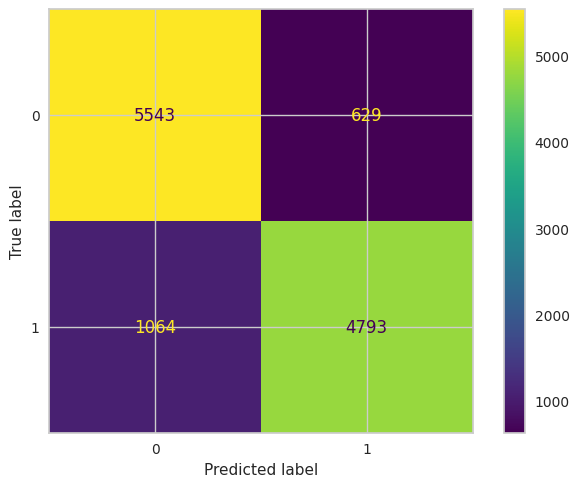

In [27]:
plot_confusion_matrix(decision_tree, X_test, y_test);

### Random Forest Classifier

In [28]:
# Instantiate the models
rf_kmodes = RandomForestClassifier()
# Fit and evaluate the Random Forest Classifier model
rf_kmodes.fit(X_train, y_train)
y_val_pred = rf_kmodes.predict(X_val)
y_test_pred = rf_kmodes.predict(X_test)
# Cross-Validate the model
cv_scores = cross_val_score(rf_kmodes, X_train_val, y_train_val, cv=5).mean()

print("RandomForest Classifier")
print(f"Accuracy on validation set: {accuracy_score(y_val, y_val_pred)}")
print(f"Accuracy on test set: {accuracy_score(y_test, y_test_pred)}")
print(f"Cross-validation score: {cv_scores}")
print(f"Classification report:\n{classification_report(y_test, y_test_pred)}\n")

RandomForest Classifier
Accuracy on validation set: 0.8592567960761494
Accuracy on test set: 0.8633302851442348
Cross-validation score: 0.8599189441961966
Classification report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      6172
           1       0.88      0.83      0.86      5857

    accuracy                           0.86     12029
   macro avg       0.86      0.86      0.86     12029
weighted avg       0.86      0.86      0.86     12029




findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

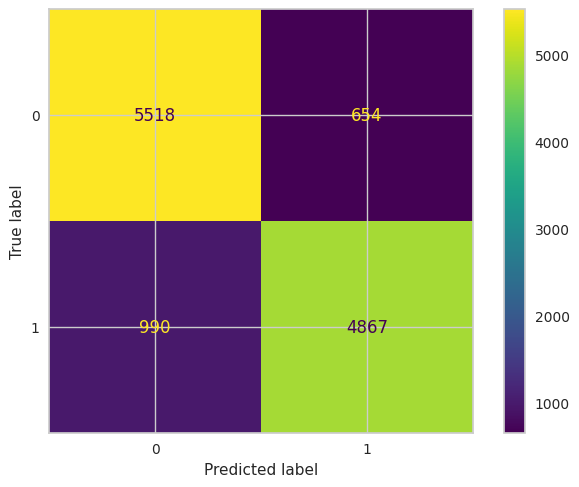

In [29]:
plot_confusion_matrix(rf_kmodes, X_test, y_test);

### Light Gradient Boost (lightgbm)

`LightGBM` extends the `gradient` boosting algorithm by adding a type of automatic feature selection as well as focusing on boosting examples with larger gradients. This can result in a dramatic speedup of training and improved predictive performance.

In [30]:
# Instantiate the models
lightgbm = LGBMClassifier()
# Fit and evaluate the Random Forest Classifier model
lightgbm.fit(X_train, y_train)
y_val_pred = lightgbm.predict(X_val)
y_test_pred = lightgbm.predict(X_test)
# Cross-Validate the model
cv_scores = cross_val_score(lightgbm, X_train_val, y_train_val, cv=5).mean()

print("Light Gradient Boost (lightgbm)")
print(f"Accuracy on validation set: {accuracy_score(y_val, y_val_pred)}")
print(f"Accuracy on test set: {accuracy_score(y_test, y_test_pred)}")
print(f"Cross-validation score: {cv_scores}")
print(f"Classification report:\n{classification_report(y_test, y_test_pred)}\n")

Light Gradient Boost (lightgbm)
Accuracy on validation set: 0.8653254634632971
Accuracy on test set: 0.8675700390722421
Cross-validation score: 0.8669229969863869
Classification report:
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      6172
           1       0.89      0.84      0.86      5857

    accuracy                           0.87     12029
   macro avg       0.87      0.87      0.87     12029
weighted avg       0.87      0.87      0.87     12029




findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

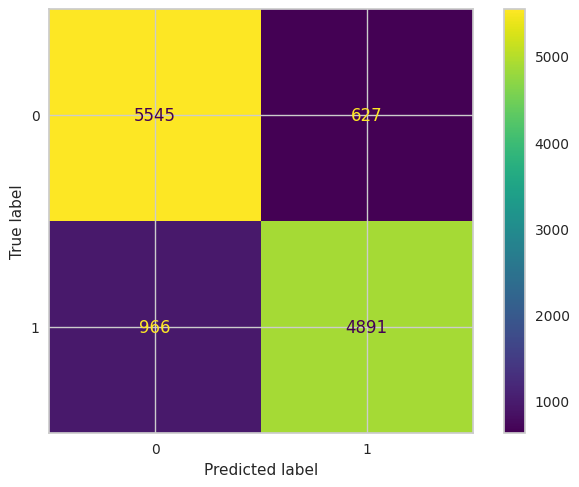

In [31]:
plot_confusion_matrix(lightgbm, X_test, y_test);

### Extreme Gradient Boosting (XGBoost)

XGBoost is an implementation of gradient boosted decision trees designed for speed and performance.

In [32]:
# Instantiate the models
xgboost = XGBClassifier()

# Fit and evaluate the Random Forest Classifier model
xgboost.fit(X_train, y_train)
y_val_pred = xgboost.predict(X_val)
y_test_pred = xgboost.predict(X_test)

# Cross-Validate the model
cv_scores = cross_val_score(xgboost, X_train_val, y_train_val, cv=5).mean()

print("Extreme Gradient Boosting (XGBoost)")
print(f"Accuracy on validation set: {accuracy_score(y_val, y_val_pred)}")
print(f"Accuracy on test set: {accuracy_score(y_test, y_test_pred)}")
print(f"Cross-validation score: {cv_scores}")
print(f"Classification report:\n{classification_report(y_test, y_test_pred)}\n")

Extreme Gradient Boosting (XGBoost)
Accuracy on validation set: 0.8620832986948208
Accuracy on test set: 0.8647435364535705
Cross-validation score: 0.8649069936610205
Classification report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      6172
           1       0.88      0.84      0.86      5857

    accuracy                           0.86     12029
   macro avg       0.87      0.86      0.86     12029
weighted avg       0.87      0.86      0.86     12029




findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

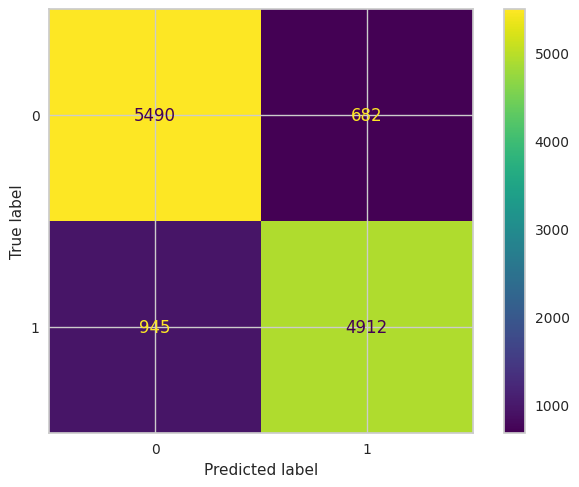

In [33]:
plot_confusion_matrix(xgboost, X_test, y_test);

### Gradient Boosting Classifier

Gradient boosting is an approach where new models are created that predict the residuals or errors of prior models and then added together to make the final prediction. It is called gradient boosting because it uses a gradient descent algorithm to minimize the loss when adding new models.

In [34]:
# Instantiate the models
gradboost_kmodes = GradientBoostingClassifier()
# Fit and evaluate the Gradientboost Classifier model
gradboost_kmodes.fit(X_train, y_train)
y_val_pred = gradboost_kmodes.predict(X_val)
y_test_pred = gradboost_kmodes.predict(X_test)
# Cross-validate the model
cv_scores = cross_val_score(gradboost_kmodes, X_train_val, y_train_val, cv=5).mean()

print("Gradientboost Classifier")
print(f"Accuracy on validation set: {accuracy_score(y_val, y_val_pred)}")
print(f"Accuracy on test set: {accuracy_score(y_test, y_test_pred)}")
print(f"Cross-validation score: {cv_scores}")
print(f"Classification report:\n{classification_report(y_test, y_test_pred)}\n")

Gradientboost Classifier
Accuracy on validation set: 0.8554327042979466
Accuracy on test set: 0.8586748690664228
Cross-validation score: 0.8563026083341994
Classification report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.87      6172
           1       0.88      0.82      0.85      5857

    accuracy                           0.86     12029
   macro avg       0.86      0.86      0.86     12029
weighted avg       0.86      0.86      0.86     12029




findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

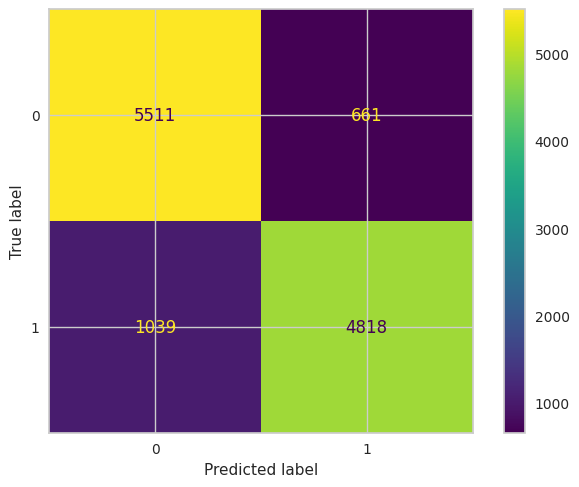

In [35]:
plot_confusion_matrix(gradboost_kmodes, X_test, y_test);

### Appending all results

In [36]:
# Define the models
models = [
    ('Decision Tree', decision_tree),
    ('Random-Forest Classifier', rf_kmodes),
    ('Light Gradientboost', lightgbm),
    ('Extreme Gradientboost', xgboost),
    ('GradientBoost Classifier', gradboost_kmodes)
]

# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

# Evaluate each model and append the results to the DataFrame
for model_name, model in models:
    # Train the model
    model.fit(X_train, y_train)

    # Evaluate the model on the validation set
    y_val_pred = model.predict(X_val)
    acc_val = accuracy_score(y_val, y_val_pred)
    p_val, r_val, f1_val, _ = precision_recall_fscore_support(y_val, y_val_pred, average='weighted')

    # Evaluate the model on the test set
    y_test_pred = model.predict(X_test)
    acc_test = accuracy_score(y_test, y_test_pred)
    p_test, r_test, f1_test, _ = precision_recall_fscore_support(y_test, y_test_pred, average='weighted')

    # Append the results to the DataFrame
    results_df = results_df.append({
        'Model': model_name,
        'Accuracy': f'Val: {acc_val:.3f}, Test: {acc_test:.3f}',
        'Precision': f'Val: {p_val:.3f}, Test: {p_test:.3f}',
        'Recall': f'Val: {r_val:.3f}, Test: {r_test:.3f}',
        'F1-Score': f'Val: {f1_val:.3f}, Test: {f1_test:.3f}'
    }, ignore_index=True)

# Print the results
results_df

,Model,Accuracy,Precision,Recall,F1-Score
0,Decision Tree,"Val: 0.856, Test: 0.859","Val: 0.858, Test: 0.861","Val: 0.856, Test: 0.859","Val: 0.856, Test: 0.859"
1,Random-Forest Classifier,"Val: 0.859, Test: 0.864","Val: 0.860, Test: 0.865","Val: 0.859, Test: 0.864","Val: 0.858, Test: 0.864"
2,Light Gradientboost,"Val: 0.865, Test: 0.868","Val: 0.866, Test: 0.869","Val: 0.865, Test: 0.868","Val: 0.865, Test: 0.867"
3,Extreme Gradientboost,"Val: 0.862, Test: 0.865","Val: 0.863, Test: 0.865","Val: 0.862, Test: 0.865","Val: 0.862, Test: 0.865"
4,GradientBoost Classifier,"Val: 0.855, Test: 0.859","Val: 0.856, Test: 0.860","Val: 0.855, Test: 0.859","Val: 0.855, Test: 0.858"


In [37]:
f1_sort = results_df.sort_values('F1-Score', ascending=False)
f1_sort

,Model,Accuracy,Precision,Recall,F1-Score
2,Light Gradientboost,"Val: 0.865, Test: 0.868","Val: 0.866, Test: 0.869","Val: 0.865, Test: 0.868","Val: 0.865, Test: 0.867"
3,Extreme Gradientboost,"Val: 0.862, Test: 0.865","Val: 0.863, Test: 0.865","Val: 0.862, Test: 0.865","Val: 0.862, Test: 0.865"
1,Random-Forest Classifier,"Val: 0.859, Test: 0.864","Val: 0.860, Test: 0.865","Val: 0.859, Test: 0.864","Val: 0.858, Test: 0.864"
0,Decision Tree,"Val: 0.856, Test: 0.859","Val: 0.858, Test: 0.861","Val: 0.856, Test: 0.859","Val: 0.856, Test: 0.859"
4,GradientBoost Classifier,"Val: 0.855, Test: 0.859","Val: 0.856, Test: 0.860","Val: 0.855, Test: 0.859","Val: 0.855, Test: 0.858"


## Hyperparameter Tuning

### Light Gradient Boost (lightgbm)

In [38]:
# Create a LightGBM model
lgbm = LGBMClassifier()

# Define the parameter grid for GridSearchCV
lgbm_params_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'max_depth': [3, 5, 7],
    'num_leaves': [7, 15, 31],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}

# Define the parameter grid for RandomSearchCV
lgbm_params_random = {
    'learning_rate': [0.01, 0.1, 1],
    'max_depth': [3, 5, 7],
    'num_leaves': [7, 15, 31],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}

In [41]:
# Perform GridSearchCV for LightGBM
lgbm_grid = GridSearchCV(lgbm, lgbm_params_grid, cv=5, scoring='accuracy')
lgbm_grid.fit(X_train, y_train)
print("LightGBM GridSearchCV Best Parameters: ", lgbm_grid.best_params_)
print("LightGBM GridSearchCV Best Score: ", lgbm_grid.best_score_)

LightGBM GridSearchCV Best Parameters:  {'learning_rate': 1, 'max_depth': 3, 'num_leaves': 7, 'reg_alpha': 0.5, 'reg_lambda': 0.5}
LightGBM GridSearchCV Best Score:  0.867510703020135


In [46]:
# Train LightGBM model with the best hyperparameters
lgbm_grid_best = LGBMClassifier(learning_rate=1, max_depth=3, num_leaves=7, reg_alpha= 0.5, reg_lambda= 0.5, random_state=42)
lgbm_grid_best.fit(X_train, y_train)

# Evaluate the model on validation set
y_pred = lgbm_grid_best.predict(X_val)
acc_val = accuracy_score(y_val, y_pred)

# Evaluate the model on test set
y_pred = lgbm_grid_best.predict(X_test)
acc_test = accuracy_score(y_test, y_pred)

# Evaluate the model using cross-validation
cv_scores = cross_val_score(lgbm_grid_best, X_train_val, y_train_val, cv=5)

# Print the performance metrics
print("Light Gradient Boost - GridSearchCV")
print("Accuracy on validation set: {:.2f}%".format(acc_val*100))
print("Accuracy on test set: {:.2f}%".format(acc_test*100))
print("Cross-validation score: {:.2f}% (+/- {:.2f}%)".format(cv_scores.mean()*100, cv_scores.std()*2*100))
print("Classification report:\n", classification_report(y_test, y_pred))

Light Gradient Boost - GridSearchCV
Accuracy on validation set: 86.39%
Accuracy on test set: 86.77%
Cross-validation score: 86.64% (+/- 0.75%)
Classification report:
               precision    recall  f1-score   support

           0       0.86      0.89      0.87      6172
           1       0.88      0.84      0.86      5857

    accuracy                           0.87     12029
   macro avg       0.87      0.87      0.87     12029
weighted avg       0.87      0.87      0.87     12029



findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

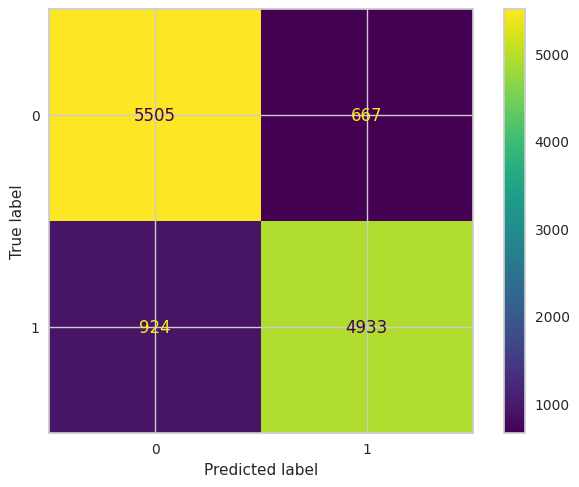

In [47]:
plot_confusion_matrix(lgbm_grid_best, X_test, y_test);

In [42]:
# Perform RandomSearchCV for LightGBM
lgbm_random = RandomizedSearchCV(lgbm, lgbm_params_random, cv=5, scoring='accuracy', n_iter=10, verbose=0)
lgbm_random.fit(X_train, y_train)
print("LightGBM RandomSearchCV Best Parameters: ", lgbm_random.best_params_)
print("LightGBM RandomSearchCV Best Score: ", lgbm_random.best_score_)

LightGBM RandomSearchCV Best Parameters:  {'reg_lambda': 0.5, 'reg_alpha': 0.5, 'num_leaves': 7, 'max_depth': 3, 'learning_rate': 1}
LightGBM RandomSearchCV Best Score:  0.867510703020135


In [48]:
# Train LightGBM model with the best hyperparameters
lgbm_rand_best = LGBMClassifier(reg_lambda= 0.5,reg_alpha= 0.5, num_leaves=7, max_depth=3, learning_rate=1, random_state=42)
lgbm_rand_best.fit(X_train, y_train)

# Evaluate the model on validation set
y_pred = lgbm_rand_best.predict(X_val)
acc_val = accuracy_score(y_val, y_pred)

# Evaluate the model on test set
y_pred = lgbm_rand_best.predict(X_test)
acc_test = accuracy_score(y_test, y_pred)

# Evaluate the model using cross-validation
cv_scores = cross_val_score(lgbm_rand_best, X_train_val, y_train_val, cv=5)

# Print the performance metrics
print("Light Gradient Boost - RandomSearchCV")
print("Accuracy on validation set: {:.2f}%".format(acc_val*100))
print("Accuracy on test set: {:.2f}%".format(acc_test*100))
print("Cross-validation score: {:.2f}% (+/- {:.2f}%)".format(cv_scores.mean()*100, cv_scores.std()*2*100))
print("Classification report:\n", classification_report(y_test, y_pred))

Light Gradient Boost - RandomSearchCV
Accuracy on validation set: 86.39%
Accuracy on test set: 86.77%
Cross-validation score: 86.64% (+/- 0.75%)
Classification report:
               precision    recall  f1-score   support

           0       0.86      0.89      0.87      6172
           1       0.88      0.84      0.86      5857

    accuracy                           0.87     12029
   macro avg       0.87      0.87      0.87     12029
weighted avg       0.87      0.87      0.87     12029



findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

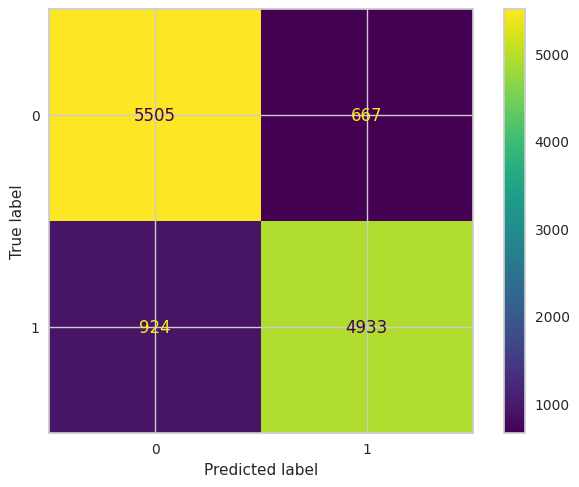

In [49]:
plot_confusion_matrix(lgbm_rand_best, X_test, y_test);

### Extreme Gradient Boosting (XGBoost)

In [43]:
# Create an XGBoost model
xgb = XGBClassifier()

# Define the parameter grid for GridSearchCV
xgb_params_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'max_depth': [3, 5, 7],
    'subsample': [0.5, 0.75, 1],
    'colsample_bytree': [0.5, 0.75, 1],
    'gamma': [0, 0.1, 0.5],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}

# Define the parameter grid for RandomSearchCV
xgb_params_random = {
    'learning_rate': [0.01, 0.1, 1],
    'max_depth': [3, 5, 7],
    'subsample': [0.5, 0.75, 1],
    'colsample_bytree': [0.5, 0.75, 1],
    'gamma': [0, 0.1, 0.5],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}

In [45]:
# # Perform GridSearchCV for XGBoost
# xgb_grid = GridSearchCV(xgb, xgb_params_grid, cv=5, scoring='accuracy')
# xgb_grid.fit(X_train, y_train)
# print("XGBoost GridSearchCV Best Parameters: ", xgb_grid.best_params_)
# print("XGBoost GridSearchCV Best Score: ", xgb_grid.best_score_)

Took too long to run sucessfully

In [50]:
# Perform RandomSearchCV for XGBoost
xgb_random = RandomizedSearchCV(xgb, xgb_params_random, cv=5, scoring='accuracy', n_iter=10)
xgb_random.fit(X_train, y_train)
print("XGBoost RandomSearchCV Best Parameters: ", xgb_random.best_params_)
print("XGBoost RandomSearchCV Best Score: ", xgb_random.best_score_)

XGBoost RandomSearchCV Best Parameters:  {'subsample': 0.75, 'reg_lambda': 0, 'reg_alpha': 0, 'max_depth': 3, 'learning_rate': 1, 'gamma': 0, 'colsample_bytree': 0.5}
XGBoost RandomSearchCV Best Score:  0.862883025374227


In [54]:
# Train XGBoost model with the best hyperparameters
xgboost_rand_best = XGBClassifier(subsample= 0.75,reg_lambda= 0,reg_alpha= 0, max_depth=3, learning_rate=1, gamma= 0, colsample_bytree= 0.5, random_state=42)
xgboost_rand_best.fit(X_train, y_train)

# Evaluate the model on validation set
y_pred = xgboost_rand_best.predict(X_val)
acc_val = accuracy_score(y_val, y_pred)

# Evaluate the model on test set
y_pred = xgboost_rand_best.predict(X_test)
acc_test = accuracy_score(y_test, y_pred)

# Evaluate the model using cross-validation
cv_scores = cross_val_score(xgboost_rand_best, X_train_val, y_train_val, cv=5)

# Print the performance metrics
print("XGBoost - RandomSearchCV")
print("Accuracy on validation set: {:.2f}%".format(acc_val*100))
print("Accuracy on test set: {:.2f}%".format(acc_test*100))
print("Cross-validation score: {:.2f}% (+/- {:.2f}%)".format(cv_scores.mean()*100, cv_scores.std()*2*100))
print("Classification report:\n", classification_report(y_test, y_pred))

XGBoost - RandomSearchCV
Accuracy on validation set: 86.19%
Accuracy on test set: 86.42%
Cross-validation score: 86.31% (+/- 0.65%)
Classification report:
               precision    recall  f1-score   support

           0       0.85      0.90      0.87      6172
           1       0.89      0.83      0.86      5857

    accuracy                           0.86     12029
   macro avg       0.87      0.86      0.86     12029
weighted avg       0.87      0.86      0.86     12029



findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

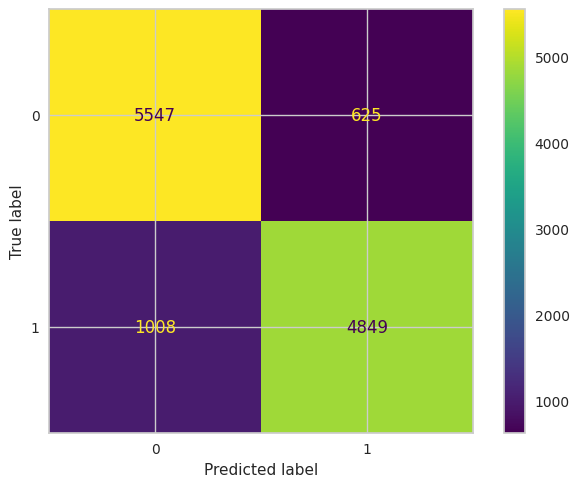

In [55]:
plot_confusion_matrix(xgboost_rand_best, X_test, y_test);

## Appending all result

In [56]:
# Define the models
models = [
    ('Decision Tree', decision_tree),
    ('Random-Forest Classifier', rf_kmodes),
    ('Light Gradientboost', lightgbm),
    ('Extreme Gradientboost', xgboost),
    ('GradientBoost Classifier', gradboost_kmodes),
    ('LightGbm GridSearchCV', lgbm_grid_best),
    ('LightGbm RandomSearchCV', lgbm_rand_best),
    ('XGBoost RandomSearchCV', xgboost_rand_best)
]

# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

# Evaluate each model and append the results to the DataFrame
for model_name, model in models:
    # Train the model
    model.fit(X_train, y_train)

    # Evaluate the model on the validation set
    y_val_pred = model.predict(X_val)
    acc_val = accuracy_score(y_val, y_val_pred)
    p_val, r_val, f1_val, _ = precision_recall_fscore_support(y_val, y_val_pred, average='weighted')

    # Evaluate the model on the test set
    y_test_pred = model.predict(X_test)
    acc_test = accuracy_score(y_test, y_test_pred)
    p_test, r_test, f1_test, _ = precision_recall_fscore_support(y_test, y_test_pred, average='weighted')

    # Append the results to the DataFrame
    results_df = results_df.append({
        'Model': model_name,
        'Accuracy': f'Val: {acc_val:.3f}, Test: {acc_test:.3f}',
        'Precision': f'Val: {p_val:.3f}, Test: {p_test:.3f}',
        'Recall': f'Val: {r_val:.3f}, Test: {r_test:.3f}',
        'F1-Score': f'Val: {f1_val:.3f}, Test: {f1_test:.3f}'
    }, ignore_index=True)

# Print the results
results_df

,Model,Accuracy,Precision,Recall,F1-Score
0,Decision Tree,"Val: 0.856, Test: 0.859","Val: 0.858, Test: 0.861","Val: 0.856, Test: 0.859","Val: 0.856, Test: 0.859"
1,Random-Forest Classifier,"Val: 0.859, Test: 0.863","Val: 0.861, Test: 0.864","Val: 0.859, Test: 0.863","Val: 0.859, Test: 0.862"
2,Light Gradientboost,"Val: 0.865, Test: 0.868","Val: 0.866, Test: 0.869","Val: 0.865, Test: 0.868","Val: 0.865, Test: 0.867"
3,Extreme Gradientboost,"Val: 0.862, Test: 0.865","Val: 0.863, Test: 0.865","Val: 0.862, Test: 0.865","Val: 0.862, Test: 0.865"
4,GradientBoost Classifier,"Val: 0.855, Test: 0.859","Val: 0.856, Test: 0.860","Val: 0.855, Test: 0.859","Val: 0.855, Test: 0.858"
5,LightGbm GridSearchCV,"Val: 0.864, Test: 0.868","Val: 0.864, Test: 0.868","Val: 0.864, Test: 0.868","Val: 0.864, Test: 0.868"
6,LightGbm RandomSearchCV,"Val: 0.864, Test: 0.868","Val: 0.864, Test: 0.868","Val: 0.864, Test: 0.868","Val: 0.864, Test: 0.868"
7,XGBoost RandomSearchCV,"Val: 0.862, Test: 0.864","Val: 0.863, Test: 0.866","Val: 0.862, Test: 0.864","Val: 0.862, Test: 0.864"


In [57]:
f1_sort = results_df.sort_values('F1-Score', ascending=False)
f1_sort

,Model,Accuracy,Precision,Recall,F1-Score
2,Light Gradientboost,"Val: 0.865, Test: 0.868","Val: 0.866, Test: 0.869","Val: 0.865, Test: 0.868","Val: 0.865, Test: 0.867"
5,LightGbm GridSearchCV,"Val: 0.864, Test: 0.868","Val: 0.864, Test: 0.868","Val: 0.864, Test: 0.868","Val: 0.864, Test: 0.868"
6,LightGbm RandomSearchCV,"Val: 0.864, Test: 0.868","Val: 0.864, Test: 0.868","Val: 0.864, Test: 0.868","Val: 0.864, Test: 0.868"
3,Extreme Gradientboost,"Val: 0.862, Test: 0.865","Val: 0.863, Test: 0.865","Val: 0.862, Test: 0.865","Val: 0.862, Test: 0.865"
7,XGBoost RandomSearchCV,"Val: 0.862, Test: 0.864","Val: 0.863, Test: 0.866","Val: 0.862, Test: 0.864","Val: 0.862, Test: 0.864"
1,Random-Forest Classifier,"Val: 0.859, Test: 0.863","Val: 0.861, Test: 0.864","Val: 0.859, Test: 0.863","Val: 0.859, Test: 0.862"
0,Decision Tree,"Val: 0.856, Test: 0.859","Val: 0.858, Test: 0.861","Val: 0.856, Test: 0.859","Val: 0.856, Test: 0.859"
4,GradientBoost Classifier,"Val: 0.855, Test: 0.859","Val: 0.856, Test: 0.860","Val: 0.855, Test: 0.859","Val: 0.855, Test: 0.858"


From the table, `LightGbm` performed better when it comes to `F1-Score` metrics, so I will implement `Voting CLassifier` and check if the`F1-Score` metric will be better.

## Voting Classifier

In [58]:
from sklearn.ensemble import VotingClassifier

voting_classifier = VotingClassifier(estimators=[('Light Gradientboost', lightgbm),
                                                ('LightGbm GridSearchCV', lgbm_grid_best)], 
                                                voting='hard'
                                    )
voting_classifier.fit(X_train,y_train)

# Evaluate the model on validation set
y_val_pred = voting_classifier.predict(X_val)
acc_val = accuracy_score(y_val, y_val_pred)
p_val, r_val, f1_val, _ = precision_recall_fscore_support(y_val, y_val_pred, average='weighted')

# Evaluate the model on test set
y_test_pred = voting_classifier.predict(X_test)
acc_test = accuracy_score(y_test, y_test_pred)
p_test, r_test, f1_test, _ = precision_recall_fscore_support(y_test, y_test_pred, average='weighted')

# Evaluate the model using cross-validation
cv_scores = cross_val_score(voting_classifier, X_train_val, y_train_val, cv=5)

# Append the results to the DataFrame
results_df = results_df.append({
    'Model': 'Voting Classifier',
    'Accuracy': f'Val: {acc_val:.3f}, Test: {acc_test:.3f}',
    'Precision': f'Val: {p_val:.3f}, Test: {p_test:.3f}',
    'Recall': f'Val: {r_val:.3f}, Test: {r_test:.3f}',
    'F1-Score': f'Val: {f1_val:.3f}, Test: {f1_test:.3f}'
}, ignore_index=True)

# Print the performance metrics
print("Voting Classifier")
print("Accuracy on validation set: {:.2f}%".format(acc_val*100))
print("Accuracy on test set: {:.2f}%".format(acc_test*100))
print("Cross-validation score: {:.2f}% (+/- {:.2f}%)".format(cv_scores.mean()*100, cv_scores.std()*2*100))
print("Classification report:\n", classification_report(y_test, y_pred))

Voting Classifier
Accuracy on validation set: 86.57%
Accuracy on test set: 86.72%
Cross-validation score: 86.67% (+/- 0.66%)
Classification report:
               precision    recall  f1-score   support

           0       0.85      0.90      0.87      6172
           1       0.89      0.83      0.86      5857

    accuracy                           0.86     12029
   macro avg       0.87      0.86      0.86     12029
weighted avg       0.87      0.86      0.86     12029



findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

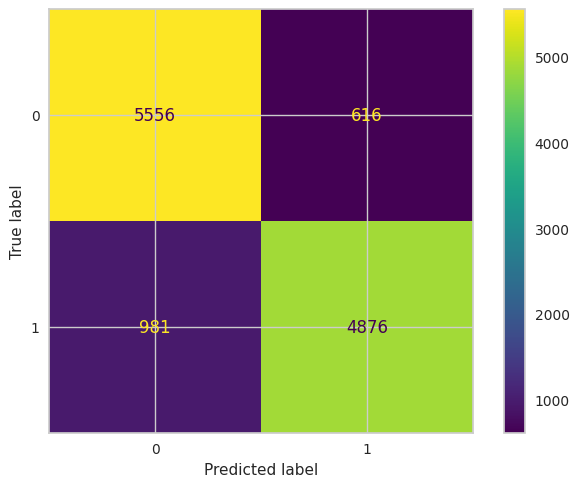

In [59]:
plot_confusion_matrix(voting_classifier, X_test, y_test);

In [60]:
results_df

,Model,Accuracy,Precision,Recall,F1-Score
0,Decision Tree,"Val: 0.856, Test: 0.859","Val: 0.858, Test: 0.861","Val: 0.856, Test: 0.859","Val: 0.856, Test: 0.859"
1,Random-Forest Classifier,"Val: 0.859, Test: 0.863","Val: 0.861, Test: 0.864","Val: 0.859, Test: 0.863","Val: 0.859, Test: 0.862"
2,Light Gradientboost,"Val: 0.865, Test: 0.868","Val: 0.866, Test: 0.869","Val: 0.865, Test: 0.868","Val: 0.865, Test: 0.867"
3,Extreme Gradientboost,"Val: 0.862, Test: 0.865","Val: 0.863, Test: 0.865","Val: 0.862, Test: 0.865","Val: 0.862, Test: 0.865"
4,GradientBoost Classifier,"Val: 0.855, Test: 0.859","Val: 0.856, Test: 0.860","Val: 0.855, Test: 0.859","Val: 0.855, Test: 0.858"
5,LightGbm GridSearchCV,"Val: 0.864, Test: 0.868","Val: 0.864, Test: 0.868","Val: 0.864, Test: 0.868","Val: 0.864, Test: 0.868"
6,LightGbm RandomSearchCV,"Val: 0.864, Test: 0.868","Val: 0.864, Test: 0.868","Val: 0.864, Test: 0.868","Val: 0.864, Test: 0.868"
7,XGBoost RandomSearchCV,"Val: 0.862, Test: 0.864","Val: 0.863, Test: 0.866","Val: 0.862, Test: 0.864","Val: 0.862, Test: 0.864"
8,Voting Classifier,"Val: 0.866, Test: 0.867","Val: 0.867, Test: 0.868","Val: 0.866, Test: 0.867","Val: 0.865, Test: 0.867"


In [61]:
f1_sort = results_df.sort_values('F1-Score', ascending=False)
f1_sort

,Model,Accuracy,Precision,Recall,F1-Score
2,Light Gradientboost,"Val: 0.865, Test: 0.868","Val: 0.866, Test: 0.869","Val: 0.865, Test: 0.868","Val: 0.865, Test: 0.867"
8,Voting Classifier,"Val: 0.866, Test: 0.867","Val: 0.867, Test: 0.868","Val: 0.866, Test: 0.867","Val: 0.865, Test: 0.867"
5,LightGbm GridSearchCV,"Val: 0.864, Test: 0.868","Val: 0.864, Test: 0.868","Val: 0.864, Test: 0.868","Val: 0.864, Test: 0.868"
6,LightGbm RandomSearchCV,"Val: 0.864, Test: 0.868","Val: 0.864, Test: 0.868","Val: 0.864, Test: 0.868","Val: 0.864, Test: 0.868"
3,Extreme Gradientboost,"Val: 0.862, Test: 0.865","Val: 0.863, Test: 0.865","Val: 0.862, Test: 0.865","Val: 0.862, Test: 0.865"
7,XGBoost RandomSearchCV,"Val: 0.862, Test: 0.864","Val: 0.863, Test: 0.866","Val: 0.862, Test: 0.864","Val: 0.862, Test: 0.864"
1,Random-Forest Classifier,"Val: 0.859, Test: 0.863","Val: 0.861, Test: 0.864","Val: 0.859, Test: 0.863","Val: 0.859, Test: 0.862"
0,Decision Tree,"Val: 0.856, Test: 0.859","Val: 0.858, Test: 0.861","Val: 0.856, Test: 0.859","Val: 0.856, Test: 0.859"
4,GradientBoost Classifier,"Val: 0.855, Test: 0.859","Val: 0.856, Test: 0.860","Val: 0.855, Test: 0.859","Val: 0.855, Test: 0.858"


In [62]:
precision_sort = results_df.sort_values('Precision', ascending=False)
precision_sort

,Model,Accuracy,Precision,Recall,F1-Score
8,Voting Classifier,"Val: 0.866, Test: 0.867","Val: 0.867, Test: 0.868","Val: 0.866, Test: 0.867","Val: 0.865, Test: 0.867"
2,Light Gradientboost,"Val: 0.865, Test: 0.868","Val: 0.866, Test: 0.869","Val: 0.865, Test: 0.868","Val: 0.865, Test: 0.867"
5,LightGbm GridSearchCV,"Val: 0.864, Test: 0.868","Val: 0.864, Test: 0.868","Val: 0.864, Test: 0.868","Val: 0.864, Test: 0.868"
6,LightGbm RandomSearchCV,"Val: 0.864, Test: 0.868","Val: 0.864, Test: 0.868","Val: 0.864, Test: 0.868","Val: 0.864, Test: 0.868"
7,XGBoost RandomSearchCV,"Val: 0.862, Test: 0.864","Val: 0.863, Test: 0.866","Val: 0.862, Test: 0.864","Val: 0.862, Test: 0.864"
3,Extreme Gradientboost,"Val: 0.862, Test: 0.865","Val: 0.863, Test: 0.865","Val: 0.862, Test: 0.865","Val: 0.862, Test: 0.865"
1,Random-Forest Classifier,"Val: 0.859, Test: 0.863","Val: 0.861, Test: 0.864","Val: 0.859, Test: 0.863","Val: 0.859, Test: 0.862"
0,Decision Tree,"Val: 0.856, Test: 0.859","Val: 0.858, Test: 0.861","Val: 0.856, Test: 0.859","Val: 0.856, Test: 0.859"
4,GradientBoost Classifier,"Val: 0.855, Test: 0.859","Val: 0.856, Test: 0.860","Val: 0.855, Test: 0.859","Val: 0.855, Test: 0.858"


From the table above, we have two models performing better which are `Voting Classifier` and `Light Gradientboost`. I'm going to save both model and this will be the end of the project.

## Saving both models

In [64]:
import pickle

pickle.dump(lightgbm, open('../../Models/lightgbm.pkl', 'wb'))

In [65]:
pickle.dump(voting_classifier, open('../../Models/voting_classifier.pkl', 'wb'))

**Author:** `Jammal Adeyemi`

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7762417b-23bb-4a3d-828e-04b3fea052ca' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>